In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
 
import warnings
warnings.filterwarnings('ignore')

This beginner ML project is classed as Classification.  Classification is essentially teaching a model to classify something with a 'label' based on the inputs we give it. In this scenario, it would be Binary Classification, meaning there is only two labels: The child is autistic, or it is not.

With only two labels, it's actually pretty easy to make a precise ML model. With just the model randomly selecting a label it'll still get 50%, just like a coin flip. So for projects like this, we really want a very high accuracy, I aim to at least get 90% accuracy.

Lets see how it goes!

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1054 entries, 0 to 1053
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Case_No                 1054 non-null   int64 
 1   A1                      1054 non-null   int64 
 2   A2                      1054 non-null   int64 
 3   A3                      1054 non-null   int64 
 4   A4                      1054 non-null   int64 
 5   A5                      1054 non-null   int64 
 6   A6                      1054 non-null   int64 
 7   A7                      1054 non-null   int64 
 8   A8                      1054 non-null   int64 
 9   A9                      1054 non-null   int64 
 10  A10                     1054 non-null   int64 
 11  Age_Mons                1054 non-null   int64 
 12  Qchat-10-Score          1054 non-null   int64 
 13  Sex                     1054 non-null   object
 14  Ethnicity               1054 non-null   object
 15  Jaun

In [4]:
df.head()

,Case_No,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,Age_Mons,Qchat-10-Score,Sex,Ethnicity,Jaundice,Family_mem_with_ASD,Who completed the test,Class/ASD Traits
0,1,0,0,0,0,0,0,1,1,0,1,28,3,f,middle eastern,yes,no,family member,No
1,2,1,1,0,0,0,1,1,0,0,0,36,4,m,White European,yes,no,family member,Yes
2,3,1,0,0,0,0,0,1,1,0,1,36,4,m,middle eastern,yes,no,family member,Yes
3,4,1,1,1,1,1,1,1,1,1,1,24,10,m,Hispanic,no,no,family member,Yes
4,5,1,1,0,1,1,1,1,1,1,1,20,9,f,White European,no,yes,family member,Yes


As we can see theres 16 different inputs that can influence the label. Lets break down the columns and see how they can influence the model:

A1-A10:

These are simple yes or no questions about the childs behaviours. Some of these questions include asking whether the child looks directly at you in the eyes, fixates on random things or is very quiet. These are the most important inputs, as they all give insight on the childs behaviours, which is what is primarily used when classifying children with autsim at young ages. I foresee these inputs will have a big impact on the model.

Qchat-10-Score:

This is the final score that adds up all the yes/no questions and gives us a number. We are actually told that anything over 3 in the score will mean that the child has ASD traits, so this again should have a strong impact on the model. The model should be able to pick up this rule and could even just use the Score itself to label them tests by itself. 

Age, Sex, Ethnicity, Juandice:

These are all biological information about the child being screened. The model might be able to find a pattern here and find links between about the childs biology and ASD traits. Maybe the model learns that white european boys are more likely to have ASD traits than others. 

There is also the Jaudice input, which is interesting. The column defines whether the child was born with Jaundice, which is a common and relatively safe condition that usually dissapears a few weeks after being born, only giving the child yellow skin and whitened eyes. It would be interesting to see if the model makes a link here, as it could indicate if theres a link between children born with Jaundice and having ASD Traits.

Family Member ASD:

This indicates whether other family members also have ASD. This will again have a strong correlation I believe since ASD can be inherited from parents, meaning if a family member has ASD the child is more likely to have it too.

DATA CLEANING

Here we will be cleaning up the data to ensure its ready for training the model. Cleaning may include null values, duplicate values, discrepancies or outliers.

In [5]:
df['Who completed the test'].value_counts()

Who completed the test
family member               1018
Health Care Professional      24
Health care professional       5
Self                           4
Others                         3
Name: count, dtype: int64

As we see here, this is an issue that'll need some cleaning. Looking at all the different values there is two labels for 'Health Care Professional', one with uppercases on the words and the other having lowercase. This will be an issue since the model will view these two as separate, when in reality there are exactly the same. To fix this we just simply reformat it so there is only one label for Health Care Professional.

In [6]:
df = df.replace('Health care professional', 'Health Care Professional')

In [7]:
df['Who completed the test'].value_counts()

Who completed the test
family member               1018
Health Care Professional      29
Self                           4
Others                         3
Name: count, dtype: int64

Explanatory Data Analysis (EDA)

Here we will do some analysis on the data with visual techniques to help us understand the data further. We do this to discover patterns or to check assumptions using graphs.

Firstly we will check the data imbalance and skewness.

In [8]:
df['Class/ASD Traits '].value_counts()

Class/ASD Traits 
Yes    728
No     326
Name: count, dtype: int64

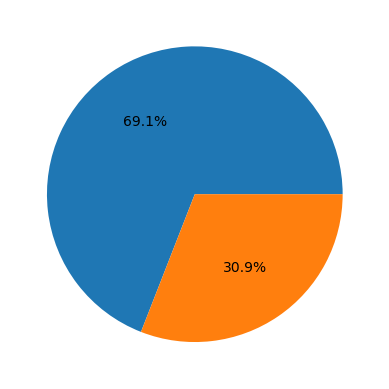

In [9]:
plt.pie(df['Class/ASD Traits '].value_counts().values, autopct='%1.1f%%')
plt.show()

As you can see there is some imbalance in the data.

When looking at the label for ASD (yes or no), we have a lot more cases with a Yes than No. This poses as an issue since when training the data, the model will have less negative cases to train itself, meaning it won't be as accurate when it comes to predicting negative cases. This will need to be addressed and fixed

Next lets have a look at the columns and see if theres any pattern we can pull out upon analysis.

In [10]:
objects = []
floats = []
 
for col in df.columns:
  if df[col].dtype == int:
    ints.append(col)
  elif df[col].dtype == object:
    objects.append(col)
  else:
    floats.append(col)

floats.remove('Case_No')
objects.remove('Class/ASD Traits ')

With this code we've now got the data separated by its type, allowing us to suitably analyse each data type. I've also removed two columns, 'Case_No' and 'Class/ASD Traits'. Case_No is just a unique identifier for each case so it has no impact on the result at all, and Class/ASD Traits is the result, so theres no point comparing the result to the results!

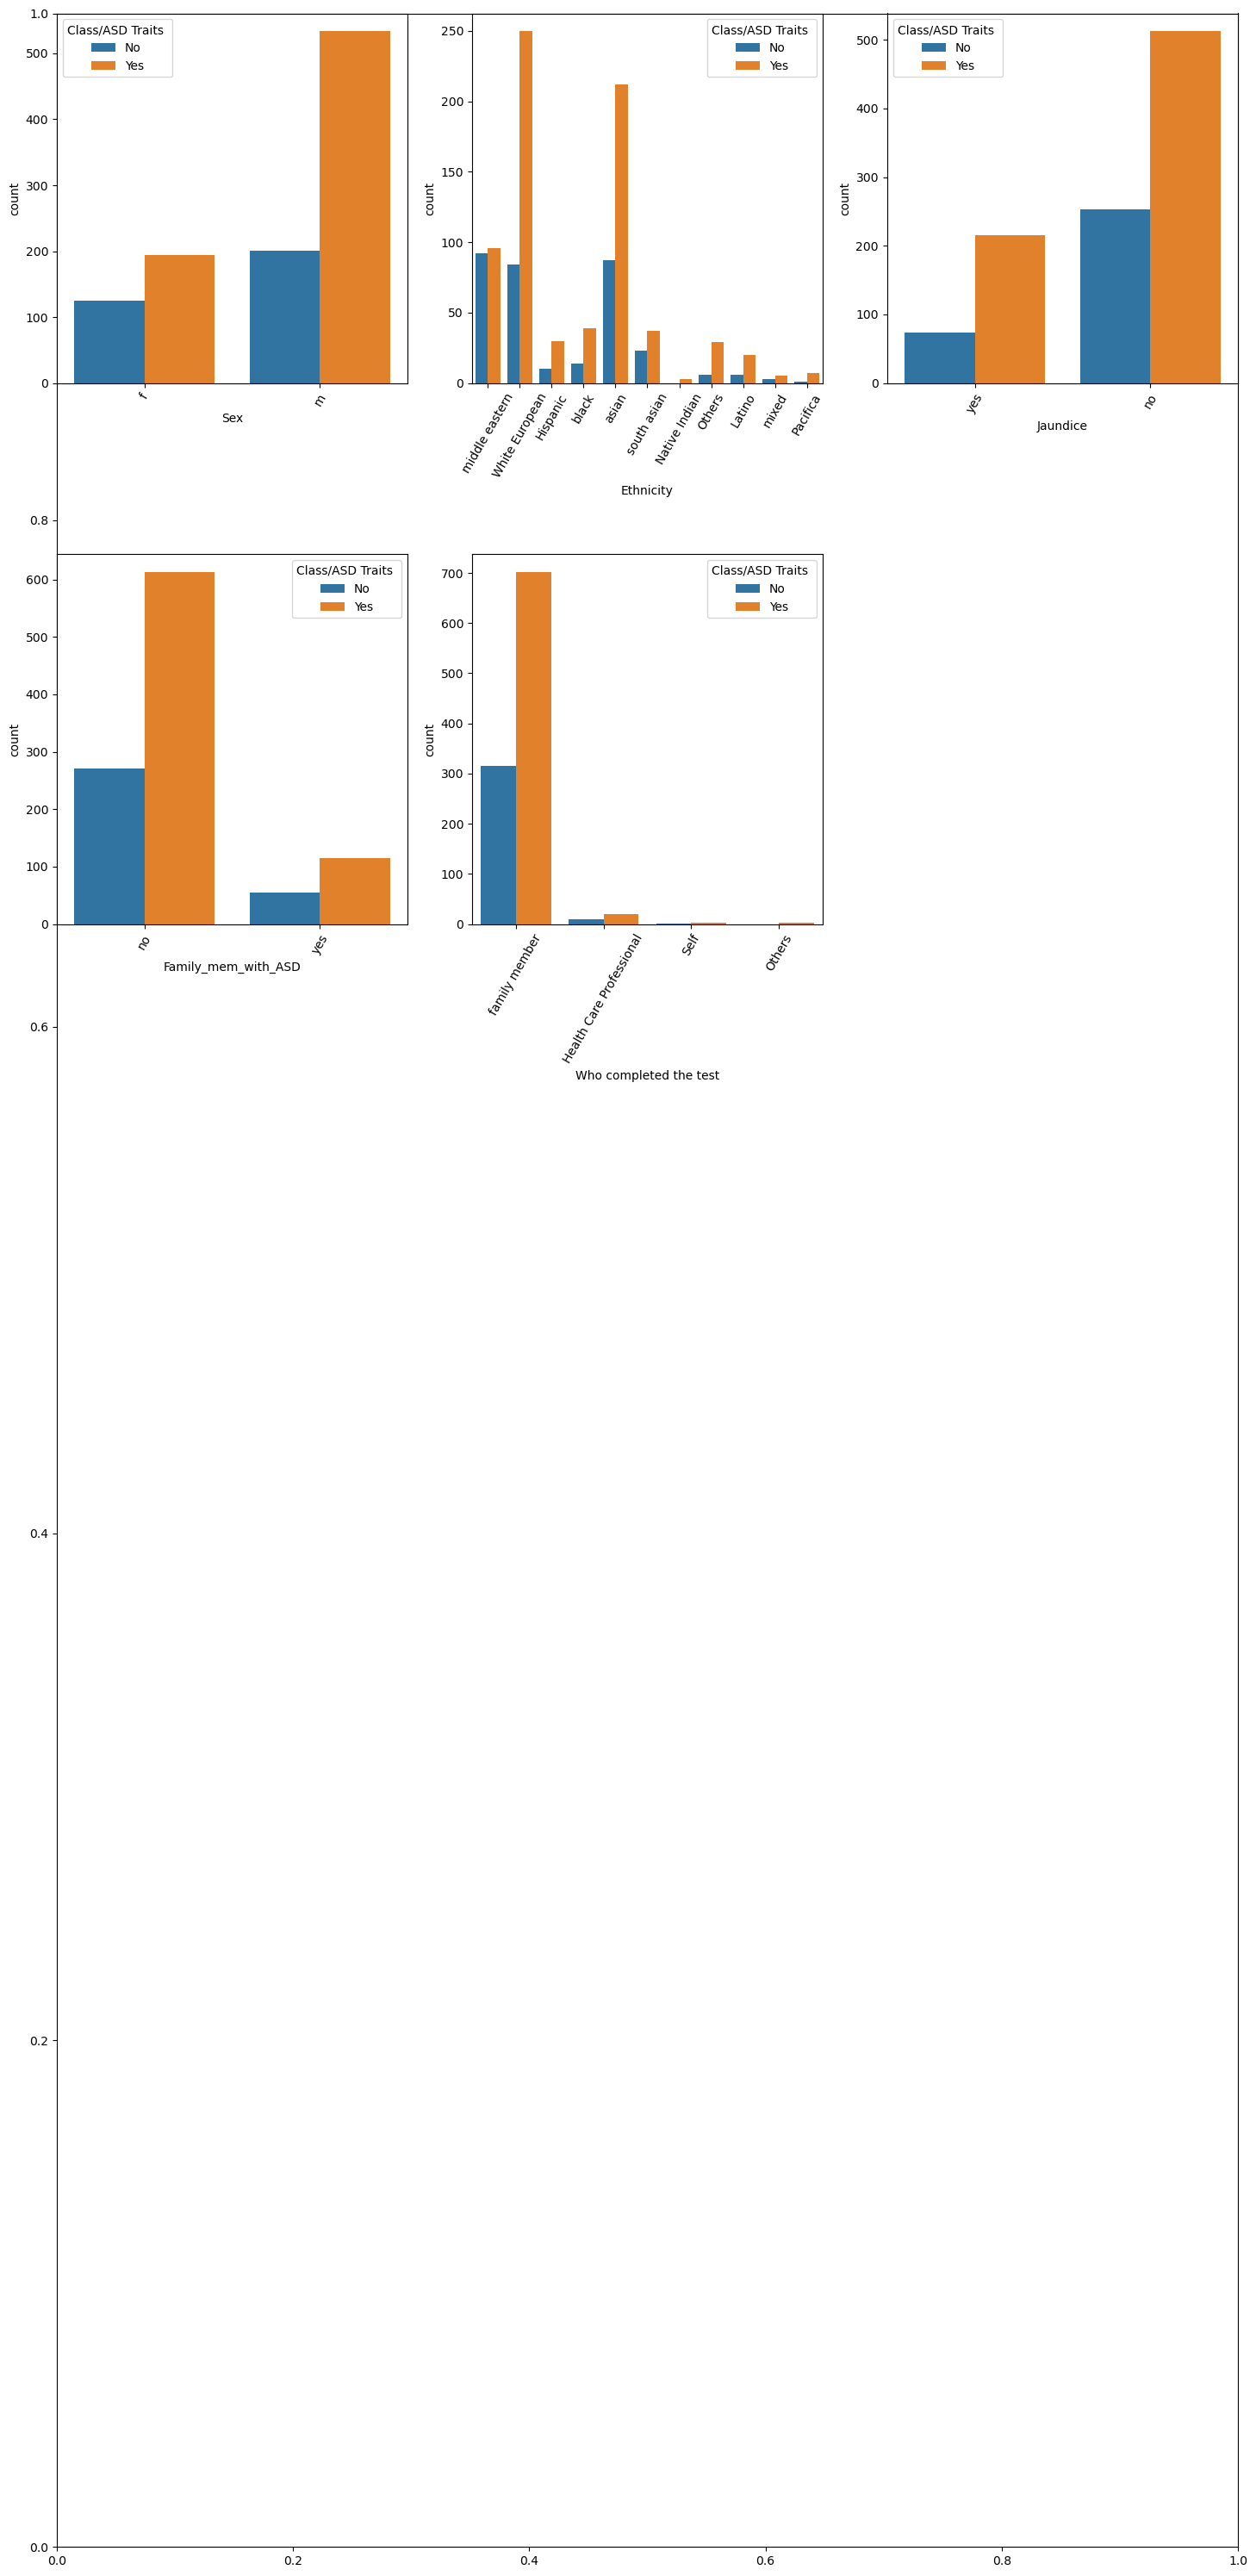

In [12]:
plt.subplots(figsize=(15, 30))

for i, col in enumerate(objects):
    plt.subplot(5, 3, i+1)
    sb.countplot(df, x=col, hue='Class/ASD Traits ')
    plt.xticks(rotation=60)
    
plt.tight_layout()
plt.show()

Upon inspection of these graphs, we can conclude a few things.

Firstly, it seems that males have a higher change of having autism, due to the large difference between positive and negative cases. However, since we don't have as many total female cases we cannot be certain until we got more female case.

Also, from the ethnicity graph it does seems that ethnicity can have an impact, as we see a large variety of differences for positive/negative cases. White european and asians seems to be most likely to have ASD traits

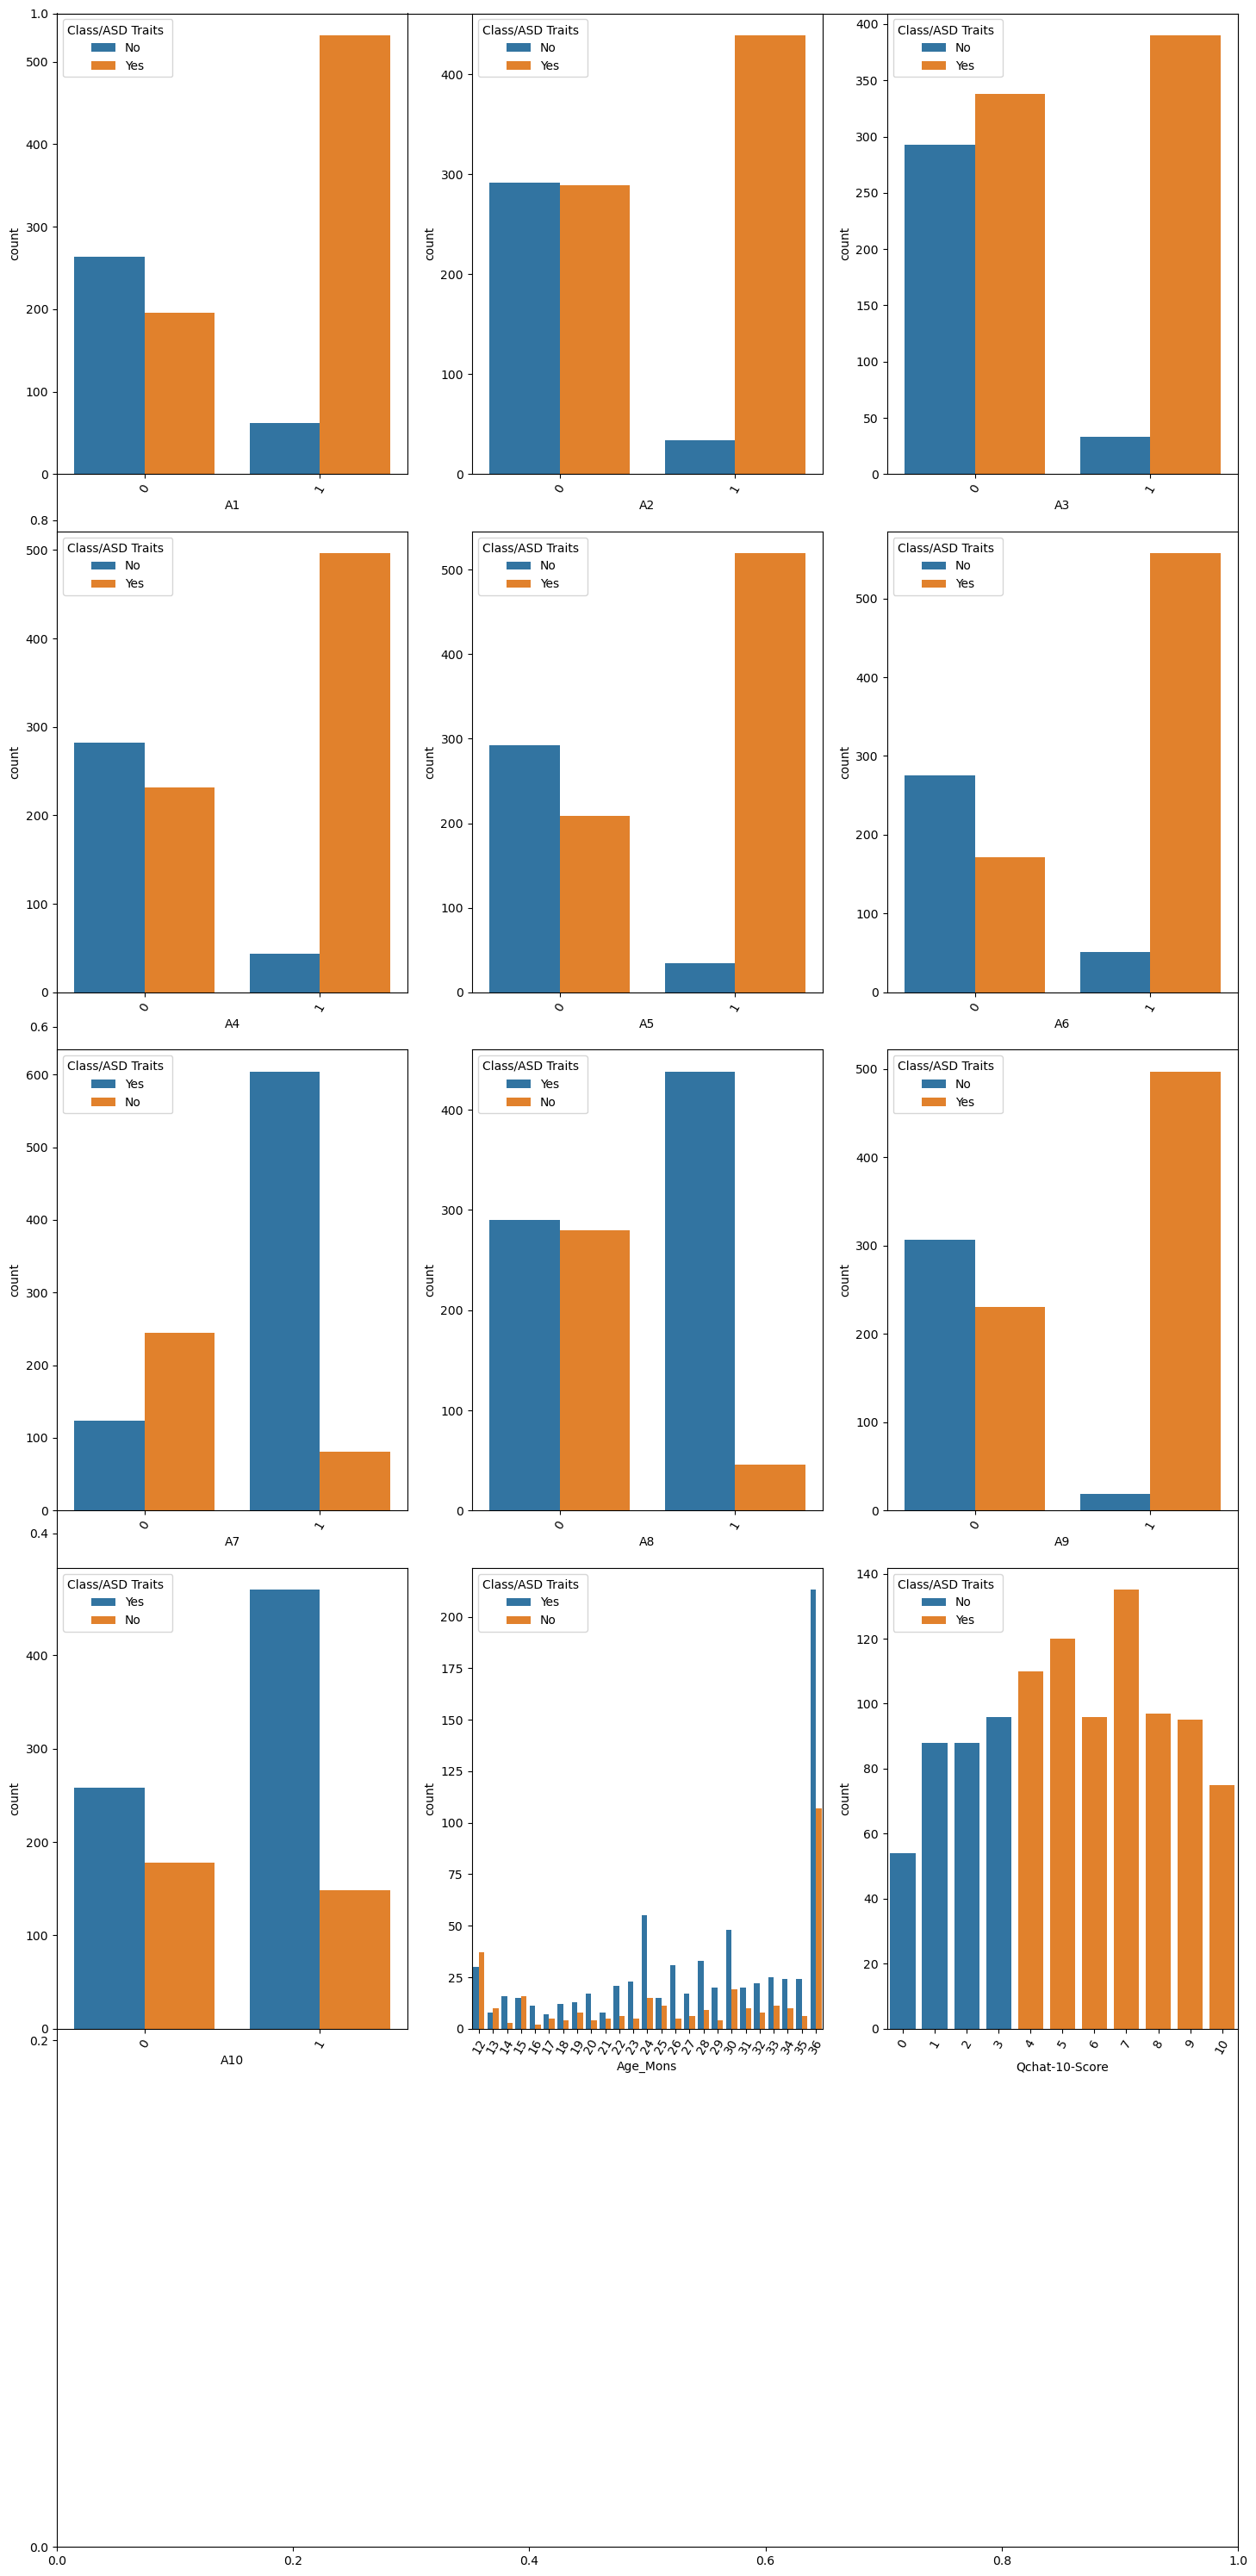

In [13]:
plt.subplots(figsize=(15, 30))

for i, col in enumerate(floats):
    plt.subplot(5, 3, i+1)
    sb.countplot(df, x=col, hue='Class/ASD Traits ')
    plt.xticks(rotation=60)
    
plt.tight_layout()
plt.show()

Upon looking at the individual scores graphs, it clearly that all the questions are well alligned with diagnosing ASD traits. This is evident since for nearly every question that has a 0, the chances for autism in that case is very low. This is not the case however for question 10. Perhaps this could mean that question 10 isn't a useful question when diagnosing a child as the data shows its not that signficiant like the others.

Also we can clearly see that any total show that is 3 or under is always a no for ASD traits, but a yes for anything over 3. This shows that there is no inaccuracies in this rule, as there is no cases where there are special exceptions.

The ages of the cases is interesting. It seems normal until the child reaches 3 year old, where there is a massive spike in tests. This could indicate that it is around 3 years old when the behaviours of the child become more outlined as ASD by the parents, and that is when they finally decide to have them screened.

Now that we better understand the data we're using, we can now go ahead and set up a ML model from training.

Firstly lets remove some columns that I think won't help the model in its predictions.

In [25]:
df.columns

Index(['Case_No', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10',
       'Age_Mons', 'Qchat-10-Score', 'Sex', 'Ethnicity', 'Jaundice',
       'Family_mem_with_ASD', 'Who completed the test', 'Class/ASD Traits '],
      dtype='object')

In [27]:
df = df.replace({'m':1, 'f':0, 'yes':1, 'no':0})
df = df.replace({'middle eastern':0, 'White European':1, 'Hispanic':2, 'black':3, 'asian':4, 'south asian':5, 'Native Indian':6, 'Others':7, 'Latino':8, 'mixed':9, 'Pacifica':10})
df = df.replace({'No':0, 'Yes':1})
df

,Case_No,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,Age_Mons,Qchat-10-Score,Sex,Ethnicity,Jaundice,Family_mem_with_ASD,Who completed the test,Class/ASD Traits
0,1,0,0,0,0,0,0,1,1,0,1,28,3,0,0,1,0,family member,0
1,2,1,1,0,0,0,1,1,0,0,0,36,4,1,1,1,0,family member,1
2,3,1,0,0,0,0,0,1,1,0,1,36,4,1,0,1,0,family member,1
3,4,1,1,1,1,1,1,1,1,1,1,24,10,1,2,0,0,family member,1
4,5,1,1,0,1,1,1,1,1,1,1,20,9,0,1,0,1,family member,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1049,1050,0,0,0,0,0,0,0,0,0,1,24,1,0,1,0,1,family member,0
1050,1051,0,0,1,1,1,0,1,0,1,0,12,5,1,3,1,0,family member,1
1051,1052,1,0,1,1,1,1,1,1,1,1,18,9,1,0,1,0,family member,1
1052,1053,1,0,0,0,0,0,0,1,0,1,19,3,1,1,0,1,family member,0


In [28]:
removal_cols = ['Case_No', 'Qchat-10-Score', 'Who completed the test']
features = df.drop(removal_cols + ['Class/ASD Traits '], axis=1)
target = df['Class/ASD Traits ']

Case_no we've discussed as irrelevant, but I chose to remove the who completed the test as I believe that will have no significance. The majority of the tests we taken by a family member so there is nothing to extract.

The Final score should also be moved as it would be too easy. The model would become overfitted. This is where the model trains itself too closely to some data, that when presented with new data, it would be too closely trained to the data that it won't be accurate. In this case the model would soon learn the simple rule that a total score of 4 and over is always a yes, and will then just be "looking" at the final score to make its decisions and nothing else. That's not what we want, as we want the model to learn that rule by itself.

Now lets split up the data for training and testing. Its common practice to have a larger training base so lets do a 80/20 split

In [29]:
X_train, X_val, Y_train, Y_val = train_test_split(features, target, test_size = 0.2, random_state=10)

Earlier we found that the training data was imbalanced, with a lot more positve cases than negative. Here we will use the Random Over Sampler to take some cases from negative cases and duplicate them, in order to make the data more balanced

In [30]:
ros = RandomOverSampler(sampling_strategy='minority',random_state=0)
X, Y = ros.fit_resample(X_train,Y_train)
X.shape, Y.shape

((1148, 15), (1148,))

We will also normalise this data. This is essential as it scales down the data, meaning that outliers won't overshadow the other values when the model goes through training. It's also a faster option as well.

In [31]:
models = [LogisticRegression(), XGBClassifier(), SVC(kernel='rbf')]

for model in models:
  model.fit(X, Y)
 
  print(f'{model} : ')
  print('Training Accuracy : ', metrics.roc_auc_score(Y, model.predict(X)))
  print('Validation Accuracy : ', metrics.roc_auc_score(Y_val, model.predict(X_val)))
  print()

LogisticRegression() : 
Training Accuracy :  0.9982578397212544
Validation Accuracy :  1.0

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) : 
Training Accuracy :  1.0
Validation Accuracy :  0.9662223741171111

SVC() : 
Training Accuracy :  0.9520905923344949
Validation Accuracy :  0.95129

It seems all the models have a high level of accuracy, with the XGBC Classifier performing outstandingly at 100%, meaning it clearly recognised the simple rule.

I would go into further analysis but since I already have model with 100% accuracy, there is nothing to improve. Looking further I will try to found more complex data to test and learn from!